In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn import metrics
# import statsmodels.api as sm
rcParams['figure.figsize'] = 11.7,8.27

### Custom Scorer For Specificity

In [2]:
def specificity_scorer(actual, y_pred_proba):
    predicted = np.round(np.delete(y_pred_proba, np.s_[0:1], axis =1).flatten()).tolist()
    actual = actual.tolist()
    false_pos = 0
    true_neg = 0
    for i,p in enumerate(predicted):
        if actual[i] == 1.0 and p == 0.0:
            false_pos += 1
        if actual[i] == 0.0 and p == 0.0:
            true_neg += 1
    return true_neg/(true_neg + false_pos)
specificity = make_scorer(specificity_scorer, needs_proba = True)

### Summary Statistics 

In [3]:
data = pd.read_csv("data.csv")
data = data.drop('id', 1)
data['diagnosis'] = data['diagnosis'].replace('M', 1.0).replace('B', 0.0)
data = data.drop('Unnamed: 32', 1)
headers = list(data)[1:]
print(data.describe())

        diagnosis  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  569.000000   569.000000    569.000000      569.000000   569.000000   
mean     0.372583    14.127292     19.289649       91.969033   654.889104   
std      0.483918     3.524049      4.301036       24.298981   351.914129   
min      0.000000     6.981000      9.710000       43.790000   143.500000   
25%      0.000000    11.700000     16.170000       75.170000   420.300000   
50%      0.000000    13.370000     18.840000       86.240000   551.100000   
75%      1.000000    15.780000     21.800000      104.100000   782.700000   
max      1.000000    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720       

Note: logistic regression does not assume that residuals are normally distributed or homoscedascticity. 

### Get Training and Test Data

In [4]:
train, test = train_test_split(data, test_size = 0.2)

y_train = train['diagnosis']
x_train = train[headers]

print(x_train.shape, y_train.shape)

y_test = test['diagnosis']
x_test = test[headers]

print(x_test.shape, y_test.shape)

#for cross-validation 
x = data[headers]
y = data['diagnosis']

(455, 30) (455,)
(114, 30) (114,)


### Exploring Correlation

In [5]:
corr = data.corr()
print(corr['diagnosis'].sort_values())

smoothness_se             -0.067016
fractal_dimension_mean    -0.012838
texture_se                -0.008303
symmetry_se               -0.006522
fractal_dimension_se       0.077972
concavity_se               0.253730
compactness_se             0.292999
fractal_dimension_worst    0.323872
symmetry_mean              0.330499
smoothness_mean            0.358560
concave points_se          0.408042
texture_mean               0.415185
symmetry_worst             0.416294
smoothness_worst           0.421465
texture_worst              0.456903
area_se                    0.548236
perimeter_se               0.556141
radius_se                  0.567134
compactness_worst          0.590998
compactness_mean           0.596534
concavity_worst            0.659610
concavity_mean             0.696360
area_mean                  0.708984
radius_mean                0.730029
area_worst                 0.733825
perimeter_mean             0.742636
radius_worst               0.776454
concave points_mean        0

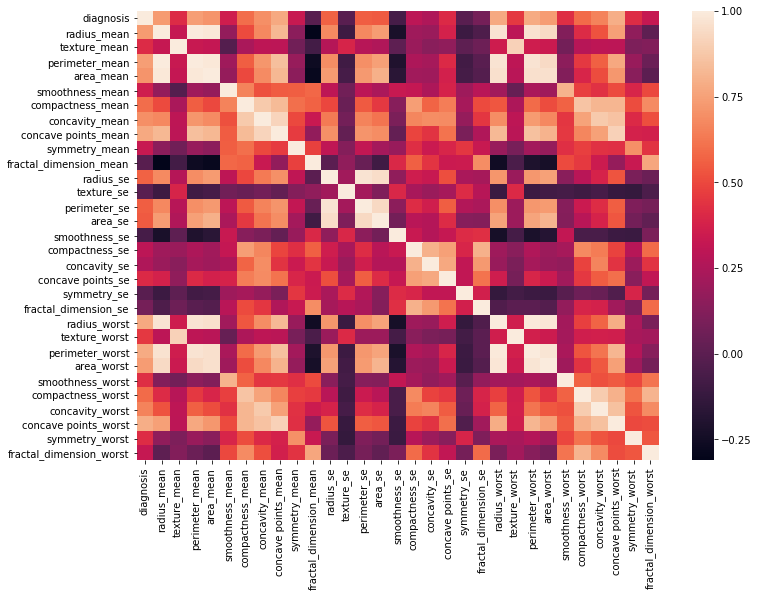

In [6]:
fig = sns.heatmap(corr, 
        #annot = True,
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

In [7]:
filtered_corr = corr.gt(.75, 0)
filtered_corr = filtered_corr.apply(lambda x: ', '.join(x.index[x]), axis = 1)

### VIF

In [8]:
# endog = y_train
# exog = sm.add_constant(x_train)
# logit = sm.Logit(endog, exog)
# result = logit.fit()

### Logistic Regression with all Parameters

In [9]:
model = LogisticRegression(C = 1e50)
model.fit(x_train, y_train)
print(model.coef_[0])

[ -6.52268653  -0.20397354   0.47226991   0.03558818   3.58751103
  -0.83285944   3.37483117   5.85415111   5.10449837  -0.75456279
   2.11973851  -3.95290055   1.56182206   0.0364769    0.5429989
  -4.87520923  -4.72443669   0.55945065  -0.49982595  -0.94006992
   1.98601951   0.64148228  -0.32531972   0.0137294    6.69842476
   1.10898908   6.7234614   11.33132402   8.87464164  -0.37491665]


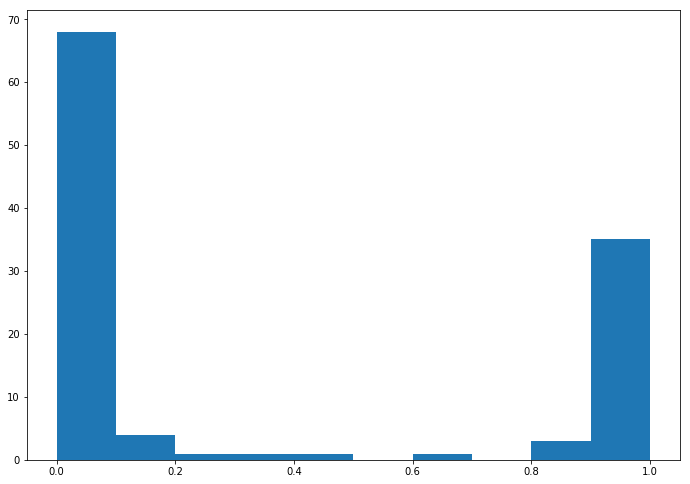

In [10]:
#need to add more bins to plot
predicted = model.predict(x_test)
probs = model.predict_proba(x_test)
probs = np.delete(probs, np.s_[0:1], axis =1).flatten()
plt.hist(probs)
plt.show()

In [11]:
print(metrics.accuracy_score(y_test, predicted))
print(metrics.roc_auc_score(y_test, probs))
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

0.947368421053
0.992820512821
[[72  3]
 [ 3 36]]
             precision    recall  f1-score   support

        0.0       0.96      0.96      0.96        75
        1.0       0.92      0.92      0.92        39

avg / total       0.95      0.95      0.95       114



In [12]:
acc = cross_val_score(LogisticRegression(C = 1e50), x, y, scoring = 'accuracy', cv = 10)
print('Accuracy:' + str(acc.mean()))
recall = cross_val_score(LogisticRegression(C = 1e50), x, y, scoring = 'recall', cv = 10)
print('Sensitivity:' + str(recall.mean()))
spec = cross_val_score(LogisticRegression(C = 1e50), x, y, scoring = specificity, cv = 10)
print('Specificity:' + str(spec.mean()))

Accuracy:0.954378402904
Sensitivity:0.929653679654
Specificity:0.960052091523


### Recursive Feature Elimination

In [13]:
rfe = RFE(model, 11) #keep 4 parameters
fit = rfe.fit(x_train, y_train)
predictors = [headers[i] for i,p in enumerate(fit.support_) if p]
print(predictors)

['compactness_mean', 'concavity_mean', 'concave points_mean', 'fractal_dimension_mean', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'symmetry_worst', 'fractal_dimension_worst']


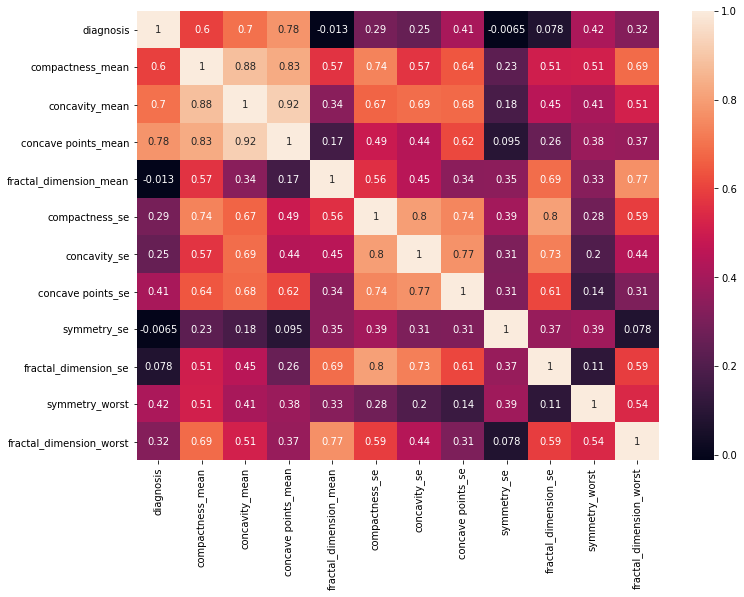

In [14]:
to_drop = list(set(headers) - set(predictors))
rfe_x = x.drop(to_drop, 1)
rfe_x_train = x_train.drop(to_drop, 1)
rfe_x_test = x_test.drop(to_drop, 1)
rfe_data = data.drop(to_drop, 1)

rfe_corr = rfe_data.corr()
fig = sns.heatmap(rfe_corr, 
        annot = True,
        xticklabels=rfe_corr.columns,
        yticklabels=rfe_corr.columns)
plt.show()

In [15]:
rfe = LogisticRegression(C=1e50)
rfe.fit(rfe_x_train, y_train)
rfe_coefficients = rfe.coef_[0]
print(rfe_coefficients)

[ -79.95774541   94.93482076   62.24349163 -341.36583176   73.15728704
 -126.09039115  351.62952275 -157.79991681 -236.25423805   28.51393228
  107.56169109]


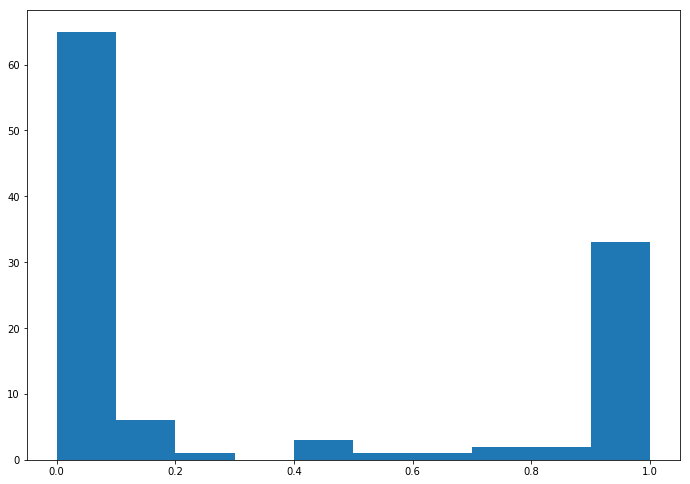

In [16]:
rfe_predicted = rfe.predict(rfe_x_test)
rfe_probs = rfe.predict_proba(rfe_x_test)
rfe_probs = np.delete(rfe_probs, np.s_[0:1], axis =1).flatten()
plt.hist(rfe_probs)
plt.show()

In [17]:
print(metrics.accuracy_score(y_test, rfe_predicted))
print(metrics.roc_auc_score(y_test, rfe_probs))
print(metrics.confusion_matrix(y_test, rfe_predicted))
print(metrics.classification_report(y_test, rfe_predicted))

0.929824561404
0.980854700855
[[71  4]
 [ 4 35]]
             precision    recall  f1-score   support

        0.0       0.95      0.95      0.95        75
        1.0       0.90      0.90      0.90        39

avg / total       0.93      0.93      0.93       114



In [18]:
acc = cross_val_score(LogisticRegression(C = 1e50), rfe_x, y, scoring = 'accuracy', cv = 10)
print('Accuracy:' + str(acc.mean()))
recall = cross_val_score(LogisticRegression(C = 1e50), rfe_x, y, scoring = 'recall', cv = 10)
print('Sensitivity:' + str(recall.mean()))
spec = cross_val_score(LogisticRegression(C = 1e50), rfe_x, y, scoring = specificity, cv = 10)
print('Specificity:' + str(spec.mean()))

Accuracy:0.931752873563
Sensitivity:0.891558441558
Specificity:0.937682309091


### Lasso Regression

In [19]:
lasso = LogisticRegression(penalty = 'l1', solver = "liblinear", C=1)
lasso.fit(x_train, y_train)
lasso_coefficients = lasso.coef_[0]
predictors = list([(headers[i], c) for i,c in enumerate(lasso_coefficients) if c != 0])
print(predictors)
print(len(predictors))

[('radius_mean', -3.4895795453315221), ('texture_mean', -0.08842494305440772), ('perimeter_mean', 0.13634837888160078), ('area_mean', 0.015660866668160647), ('texture_se', -1.4544025952692601), ('area_se', 0.094106231841300542), ('texture_worst', 0.33331404348481813), ('perimeter_worst', 0.039989883369759942), ('area_worst', 0.015654106153455548), ('concavity_worst', 4.6735406881152866)]
10


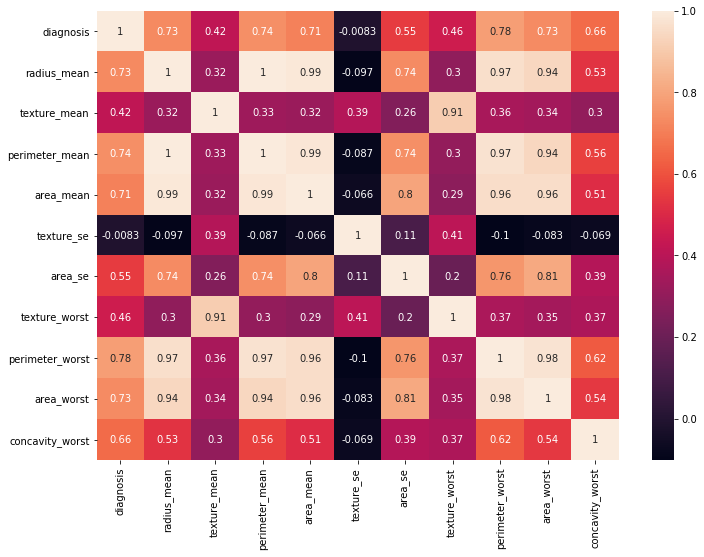

In [20]:
to_drop = list(set(headers) - set([p[0] for p in predictors]))
lasso_data = data.drop(to_drop, 1)
lasso_corr = lasso_data.corr()
fig = sns.heatmap(lasso_corr, 
        annot = True,
        xticklabels=lasso_corr.columns,
        yticklabels=lasso_corr.columns)
plt.show()

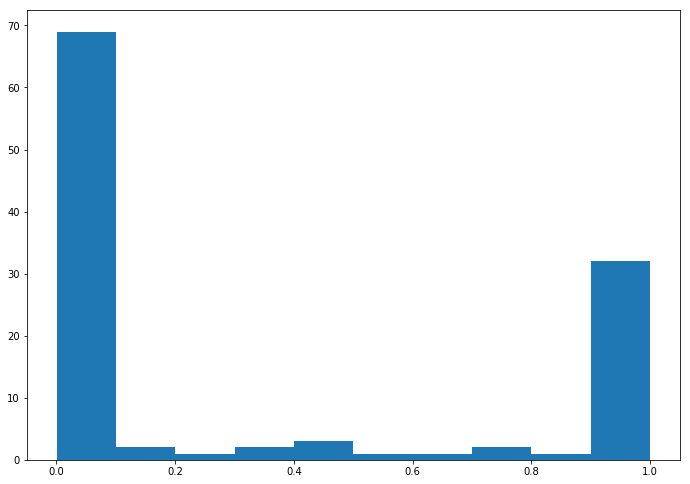

In [21]:
lasso_predicted = lasso.predict(x_test)
lasso_probs = lasso.predict_proba(x_test)
lasso_probs = np.delete(lasso_probs, np.s_[0:1], axis =1).flatten()
plt.hist(lasso_probs)
plt.show()

In [22]:
print(metrics.accuracy_score(y_test, lasso_predicted))
print(metrics.roc_auc_score(y_test, lasso_probs))
print(metrics.confusion_matrix(y_test, lasso_predicted))
print(metrics.classification_report(y_test, lasso_predicted))

0.947368421053
0.994188034188
[[73  2]
 [ 4 35]]
             precision    recall  f1-score   support

        0.0       0.95      0.97      0.96        75
        1.0       0.95      0.90      0.92        39

avg / total       0.95      0.95      0.95       114



In [23]:
acc = cross_val_score(LogisticRegression(penalty = 'l1', solver = "liblinear", C=1), x, y, scoring = 'accuracy', cv = 10)
print('Accuracy:' + str(acc.mean()))
recall = cross_val_score(LogisticRegression(penalty = 'l1', solver = "liblinear", C=1), x, y, scoring = 'recall', cv = 10)
print('Sensitivity:' + str(recall.mean()))
spec = cross_val_score(LogisticRegression(penalty = 'l1', solver = "liblinear", C=1), x, y, scoring = specificity, cv = 10)
print('Specificity:' + str(spec.mean()))

Accuracy:0.950869630974
Sensitivity:0.915584415584
Specificity:0.952681079396


### Random Forest for Variable Selection

In [24]:
random_forest = RandomForestClassifier(n_estimators = 10000)
random_forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
features = list(zip(headers, random_forest.feature_importances_))
sorted_features = sorted(features, key = lambda x:x[1], reverse = True)
print(sorted_features)

[('perimeter_worst', 0.12786046377668037), ('area_worst', 0.12058809822642724), ('concave points_worst', 0.1195320498574865), ('radius_worst', 0.117991408129149), ('concave points_mean', 0.098173707970541799), ('area_mean', 0.052758103280908651), ('perimeter_mean', 0.044178848208722525), ('concavity_mean', 0.043614941973906939), ('radius_mean', 0.039567010205654847), ('concavity_worst', 0.035503966208448409), ('area_se', 0.033521658355117293), ('compactness_worst', 0.01732424783041318), ('texture_worst', 0.016701210807645969), ('symmetry_worst', 0.014827179691069659), ('smoothness_worst', 0.01413921309892072), ('perimeter_se', 0.013616964511904316), ('radius_se', 0.013339252992854971), ('texture_mean', 0.012601902409273233), ('compactness_mean', 0.010582771473508197), ('fractal_dimension_worst', 0.0076113745624044197), ('smoothness_mean', 0.0062047921695235616), ('fractal_dimension_se', 0.005447366727287648), ('concavity_se', 0.0053066079580992133), ('texture_se', 0.0048962537513791643

In [26]:
#identify features that have an importance of more than 0.03
sfm = SelectFromModel(random_forest, threshold = 0.03)
sfm.fit(x_train, y_train)
predictors = []
for feature_list_index in sfm.get_support(indices=True):
    predictors.append(headers[feature_list_index])
print(predictors)
print(len(predictors))

['radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean', 'area_se', 'radius_worst', 'perimeter_worst', 'area_worst', 'concavity_worst', 'concave points_worst']
11


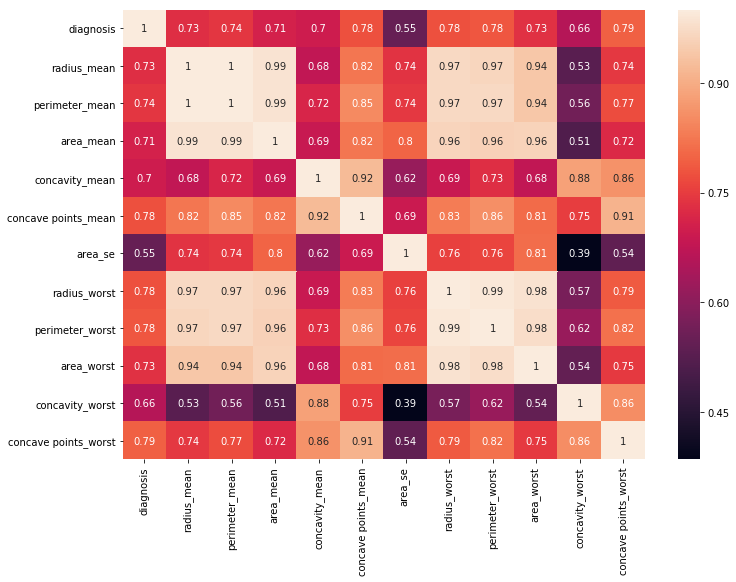

In [27]:
to_drop = list(set(headers) - set(predictors))
rf_data = data.drop(to_drop, 1)
rf_corr = rf_data.corr()
fig = sns.heatmap(rf_corr, 
        annot = True,
        xticklabels=rf_corr.columns,
        yticklabels=rf_corr.columns)
plt.show()

In [28]:
x_important_train = sfm.transform(x_train)
x_important_test = sfm.transform(x_test)
x_important = sfm.transform(x)
rf = LogisticRegression(C=1e50)
rf.fit(x_important_train, y_train)
print(rf.coef_)

[[ -5.64423933e+00   2.94773790e-01   2.67518187e-02   2.94864861e-01
    2.92516144e+00   4.73309738e-02   2.47748321e+00  -7.29822292e-02
    1.51612827e-03   5.71576125e+00   6.82430305e+00]]


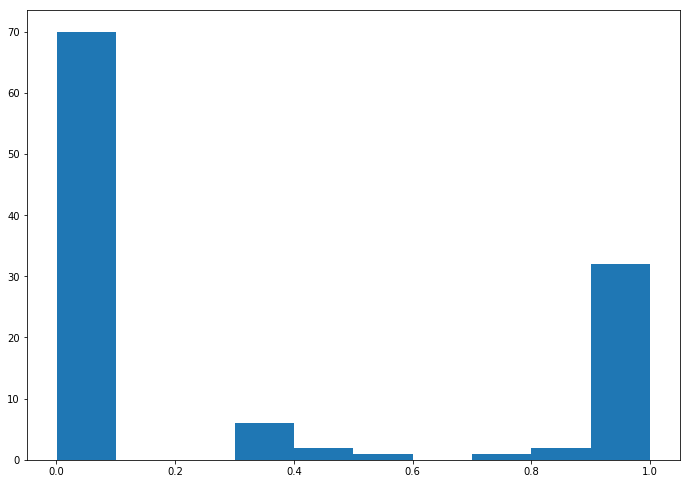

In [29]:
rf_predicted = rf.predict(x_important_test)
rf_probs = rf.predict_proba(x_important_test)
rf_probs = np.delete(rf_probs, np.s_[0:1], axis =1).flatten()
plt.hist(rf_probs)
plt.show()

In [30]:
print(metrics.accuracy_score(y_test, rf_predicted))
print(metrics.roc_auc_score(y_test, rf_probs))
print(metrics.confusion_matrix(y_test, rf_predicted))
print(metrics.classification_report(y_test, rf_predicted))

0.956140350877
0.988717948718
[[74  1]
 [ 4 35]]
             precision    recall  f1-score   support

        0.0       0.95      0.99      0.97        75
        1.0       0.97      0.90      0.93        39

avg / total       0.96      0.96      0.96       114



Note: With only one feature (perimeter worst), we are 88.6% acccurate

In [31]:
acc = cross_val_score(LogisticRegression(C = 1e50), x_important, y, scoring = 'accuracy', cv = 10)
print('Accuracy:' + str(acc.mean()))
recall = cross_val_score(LogisticRegression(C = 1e50), x_important, y, scoring = 'recall', cv = 10)
print('Sensitivity:' + str(recall.mean()))
spec = cross_val_score(LogisticRegression(C = 1e50), x_important, y, scoring = specificity, cv = 10)
print('Specificity:' + str(spec.mean()))

Accuracy:0.945635640826
Sensitivity:0.920346320346
Specificity:0.95451731807
